数据扩充可以看作是对数据的不变性的先验知识的注入。扩充数据可以覆盖未探索的输入空间，防止过拟合，提高DL模型的泛化能力[6]。在图像识别中，众所周知，抖动、缩放、裁剪、扭曲和旋转引起的微小变化不会改变数据标签，因为它们很可能发生在真实世界的观察中。然而，可穿戴传感器数据的标签保留转换并不明显且直观地可识别（图2）。

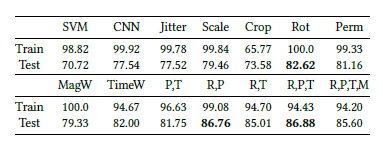
抖动不能改善分类的性能

裁剪也会失败，因为它丢弃了2/3窗口样本的信息，对无事件区域的裁剪也会阻碍学习过程

缩放和幅度扭曲也失败，因为改变信号的强度可能会改变标签。
# 处理后要画出来看一下，最后实验所用的数据扩增要尝试不同的方法

In [153]:
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
import numpy as np
import pywt
import matplotlib.pyplot as plt

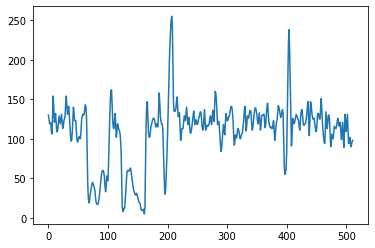

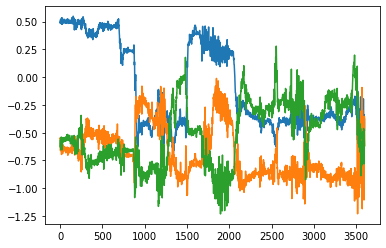

(512,) (3600, 3)


In [154]:
myX = pywt.data.camera()[500,:]
plt.plot(myX)
plt.show()
#　二维数据
my =  np.load('e:\Downloads\Compressed\Data-Augmentation-For-Wearable-Sensor-Data-master\X_sample.npy') 
plt.plot(my)
plt.show()
print(myX.shape, my.shape)

# 抖动,添加噪声    

超参数：sigma =噪声的标准偏差（STD）

抖动”可以被视为“对每个样本施加不同的噪声”。

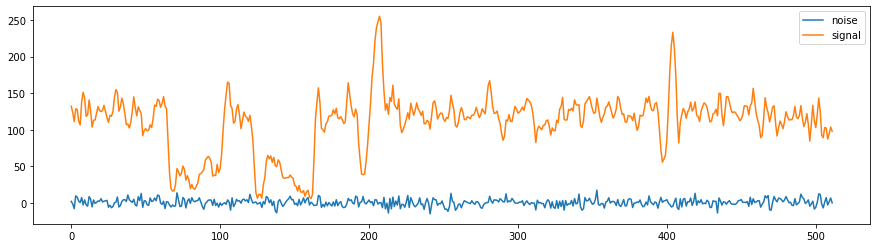

In [10]:

sigma = 5
def DA_Jitter(X, sigma=0.05):  
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    plt.plot(myNoise, label='noise')
    return X+myNoise
plt.figure(figsize=(15,4))
plt.plot(DA_Jitter(myX, sigma), label='signal')
plt.legend()

# 缩放 
超参数:σ=放大/缩小系数的标准值

通过乘以一个随机标量来更改窗口中数据的大小，是“对整个样本施加恒定的噪声”

scalingFactor [-0.9458005]


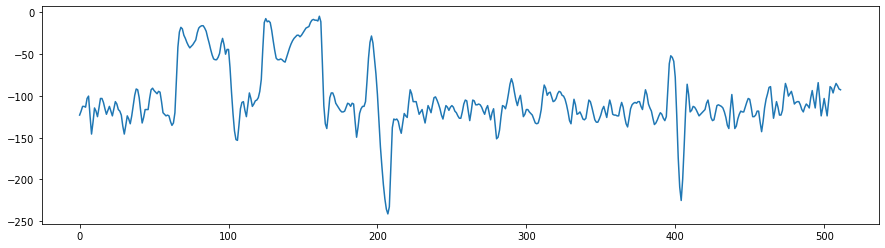

In [11]:

sigma = 5
def DA_Scaling(X, sigma=0.1):
    # 三维
    # scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=X.shape[1]) # shape=(1,3)
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1))
    print('scalingFactor', scalingFactor)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise
plt.figure(figsize=(15,4))
plt.plot(DA_Scaling(myX, sigma))

# 幅值变形 
超参数：sigma =用于生成曲线的随机结的STD 结数=随机曲线的结数（曲线的复杂度）
通过将数据窗口与围绕1变化的平滑曲线进行卷积来更改每个采样的幅值。。可视为“将平滑变化的噪声应用于整个样本”

使用三次拼接的示例并不是生成随机曲线的最佳方法。可以使用其他方法，例如高斯过程回归，贝塞尔曲线等。


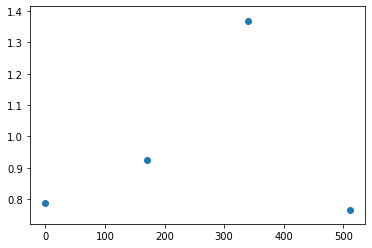

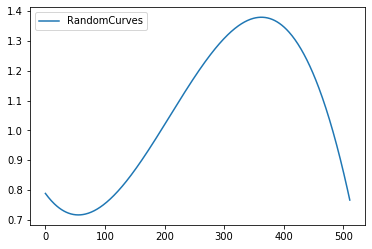

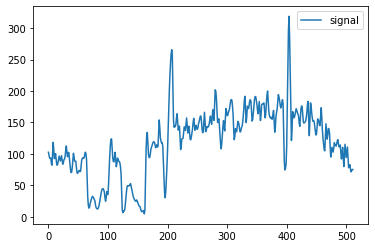

In [163]:

sigma = 0.2
knot = 2

# 生成points,在点上随机生成以1为中心的随机点,再插值。生成曲线
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    points = (np.arange(0, X.shape[0], (X.shape[0]-1)/(knot+1)))  # range from 0 to n sep=(n-1)/(knot+1)
    
    # 二维
#     dims = np.ones((X.shape[1],1))
#     xx = (dims*points).transpose()   # (3, 1)*(6,)=(6, 3)
#     yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))  # (6, 3)

#     x_indexs = np.arange(X.shape[0])
# x：包含自变量值的一维数组。y包含因变量值的数组。CubicSpline三次样条插值 计算输入数据点的分维三次样条
#     cs_x = CubicSpline(xx[:,0], yy[:,0])  
#     cs_y = CubicSpline(xx[:,1], yy[:,1])
#     cs_z = CubicSpline(xx[:,2], yy[:,2])
#     rc = np.array([cs_x(x_indexs),cs_y(x_indexs),cs_z(x_indexs)]).transpose()   # (3, 3600) -》(3600, 3)
 

    # 一维
    dims = np.ones(1)
    xx = (dims*points).transpose()   # (1)*(6,)=(6,)
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))  # (6,)
    plt.scatter(xx, yy, label='yy')
    plt.show()
    x_indexs = np.arange(X.shape[0])
    cs_x = CubicSpline(xx, yy)  # CubicSpline三次样条插值 计算输入数据点的分维三次样条
    rc = np.array([cs_x(x_indexs)])[0]  # (512,)
    return rc          

    
def DA_MagWarp(X, sigma):
    rc = GenerateRandomCurves(X, sigma,  knot)
    plt.plot(rc, label='RandomCurves')
    plt.legend()
    plt.show()
    return X * rc

plt.plot(DA_MagWarp(myX, sigma), label='signal')
plt.legend()

# 时间扭曲 

超参数：sigma =用于生成曲线的随机结的STD 结数=随机曲线的结数（曲线的复杂度）

扰动时间位置的方法。通过平滑地扭曲样本之间的时间间隔，可以使用时间扭曲来改变样本的时间位置。


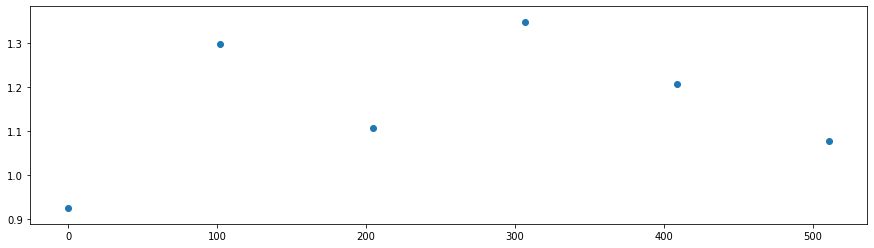

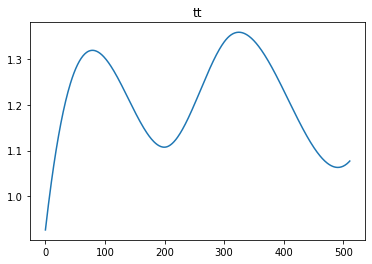

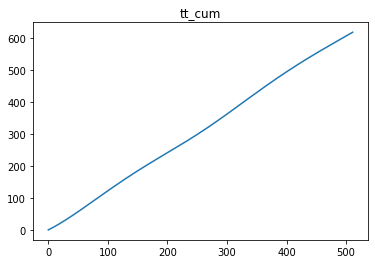

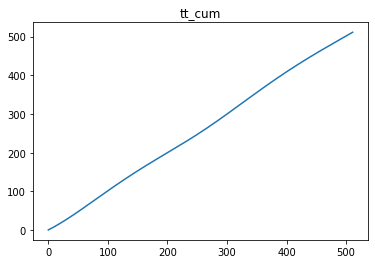

[ 0.76423056  1.53783681  2.32065281  3.11251384  3.91325638  4.72271809
  5.54073785  6.36715573  7.201813    8.04455214  8.89521682  9.75365192
 10.6197035  11.49321885 12.37404643 13.26203591 14.15703819 15.05890532
 15.96749058 16.88264844]


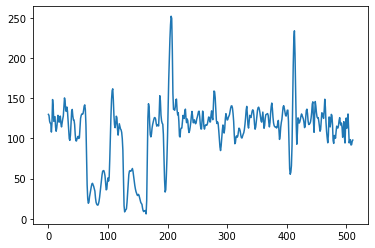

In [103]:
sigma = 0.2
knot = 4

# # ------------二维
# # 生成points,在点上随机生成以1为中心的随机点,再插值。生成曲线
# def GenerateRandomCurves(X, sigma=0.2, knot=4):
#     points = (np.arange(0, X.shape[0], (X.shape[0]-1)/(knot+1)))  # range from 0 to n sep=(n-1)/(knot+1)
    
    
#     dims = np.ones((X.shape[1],1))
#     xx = (dims*points).transpose()   # (3, 1)*(6,)=(6, 3)
#     yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))  # (6, 3)

#     x_indexs = np.arange(X.shape[0])
#     # x：包含自变量值的一维数组。y包含因变量值的数组。CubicSpline三次样条插值 计算输入数据点的分维三次样条
#     cs_x = CubicSpline(xx[:,0], yy[:,0])  
#     cs_y = CubicSpline(xx[:,1], yy[:,1])
#     cs_z = CubicSpline(xx[:,2], yy[:,2])
#     rc = np.array([cs_x(x_indexs),cs_y(x_indexs),cs_z(x_indexs)]).transpose()   # (3, 3600) -》(3600, 3)
    
#     return rc    

# def DistortTimesteps(X, sigma=0.2):
#     tt = GenerateRandomCurves(X, sigma) # (3600, 3)将这些样本在1左右作为时间间隔 
#     # np.cumsum axis=0，按照行累加。 axis=1，按照列累加,axis不给定具体值，就把numpy数组当成一个一维数组。
#     #  a=np.array([[1, 2, 3],[4, 5, 6],[7,8,9]])   np.cumsum(a,axis=0)  array([[1, 2, 3],[5, 7, 9]])   
#     tt_cum = np.cumsum(tt, axis=0)        # (3600, 3)添加间隔，形成累积图 
#     plt.plot(tt)
#     plt.title('tt')
#     plt.show()
#     plt.plot(tt_cum)
#     plt.title('tt_cum')
#     plt.show()
  
#     # Make the last value to have X.shape[0]
#     t_scale = [(X.shape[0]-1)/tt_cum[-1,0],  # (n-1)/最后一行第一列(每个点的偏离累加和)
#                (X.shape[0]-1)/tt_cum[-1,1],
#                (X.shape[0]-1)/tt_cum[-1,2]]  # [1.0426020573284123, 0.9483426614202899, 1.1870496857214778] 
    
#     tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
#     tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
#     tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
#     plt.plot(tt_cum)
#     plt.title('tt_cum')
#     plt.show()
#     return tt_cum

# # DistortTimesteps生成新的时间点，再结合原来的y值进行插值
# def DA_TimeWarp(X, sigma=0.2):
#     time_point_new = DistortTimesteps(X, sigma)  # (3600, 3)
#     print(time_point_new[:20, 0])
#     X_new = np.zeros(X.shape)
#     x_range = np.arange(X.shape[0])
#     # np.interp一维线性插值x: 数组待插入数据的横坐标,原始数据点的横坐标,原始数据点的纵坐标
#     X_new[:,0] = np.interp(x_range, time_point_new[:,0], X[:,0])  
#     X_new[:,1] = np.interp(x_range, time_point_new[:,1], X[:,1])
#     X_new[:,2] = np.interp(x_range, time_point_new[:,2], X[:,2])
#     return X_new

# plt.figure(figsize=(15,4))
# plt.plot(DA_TimeWarp(my, sigma))


# ------------------一维
# 生成points,在点上随机生成以1为中心的随机点,再插值。生成曲线
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    points = (np.arange(0, X.shape[0], (X.shape[0]-1)/(knot+1)))  # range from 0 to n sep=(n-1)/(knot+1) 
    dims = np.ones(1)
    xx = (dims*points).transpose()   # (1)*(6,)=(6,)
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2))  # (6,)
    plt.scatter(xx, yy, label='yy')
    plt.show()
    x_indexs = np.arange(X.shape[0])
    cs_x = CubicSpline(xx, yy)  # CubicSpline三次样条插值 计算输入数据点的分维三次样条
    rc = np.array([cs_x(x_indexs)])[0]  # (512,)
    return rc    

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) # (512)将这些样本在1左右作为时间间隔 
    # np.cumsum axis=0，按照行累加。 axis=1，按照列累加,axis不给定具体值，就把numpy数组当成一个一维数组。
    #  a=np.array([[1, 2, 3],[4, 5, 6],[7,8,9]])   np.cumsum(a,axis=0)  array([[1, 2, 3],[5, 7, 9]])   
    tt_cum = np.cumsum(tt)        # (512)添加间隔，形成累积图 
    plt.plot(tt)
    plt.title('tt')
    plt.show()
    plt.plot(tt_cum)
    plt.title('tt_cum')
    plt.show()
  
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1],  # (n-1)/最后一行第一列(每个点的偏离累加和)
                                 ]  # [1.0426020573284123, 0.9483426614202899, 1.1870496857214778] 
    tt_cum = tt_cum*t_scale
    plt.plot(tt_cum)
    plt.title('tt_cum')
    plt.show()
    return tt_cum

# DistortTimesteps生成新的时间点，再结合原来的y值进行插值
def DA_TimeWarp(X, sigma=0.2):
    time_point_new = DistortTimesteps(X, sigma)  # (3600, 3)
    print(time_point_new[:20])
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    # np.interp一维线性插值x: 数组待插入数据的横坐标,原始数据点的横坐标,原始数据点的纵坐标
    X_new = np.interp(x_range, time_point_new, X)
    return X_new

plt.figure(figsize=(15,4))
plt.plot(DA_TimeWarp(myX, sigma))

# 旋转 

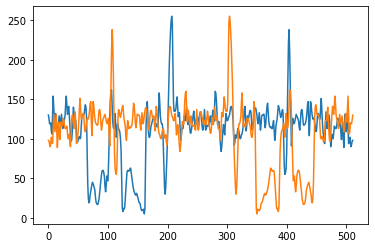

In [69]:

# # 二维
# # def DA_Rotation(X):
# #     axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
# #     angle = np.random.uniform(low=-np.pi, high=np.pi)
# #     print(axangle2mat(axis, angle).shape, axis.shape,angle) # (3, 3) (3,) -2.3947874984306092
# #     # (3600, 3) axangle2mat  Return axis, angle and point from (3, 3) matrix mat
# #     # 旋转矩阵（Rotation matrix）是在乘以一个向量的时候有改变向量的方向但不改变大小的效果并保持了手性的矩阵
# #     # \vec v=（x,y,z）M(\vec v,\theta)=\begin{bmatrix}cos\theta+(1-cos\theta)x^2 & (1-cos\theta)xy-(sin\theta)z & (1-cos\theta)xz+(sin\theta)y \\
# # # (1-cos\theta)yx+(sin\theta)z & cos\theta+(1-cos\theta)y^2 & (1-cos\theta)yz-(sin\theta)x \\
# # # (1-cos\theta)zx - (sin\theta)y & (1-cos\theta)zy+(sin\theta)x & cos\theta+(1-cos\theta)z^2
# # # \end{bmatrix}
# #     rt = np.matmul(X , axangle2mat(axis, angle))  
# #     return rt
# # plt.figure(figsize=(15,4))
# # plt.plot(DA_Rotation(my))

# # flip()    沿着指定的轴反转元素   维度是从外到内，最外是0，最内是2
# # A  array([[[0, 1],[2, 3]],[[4, 5],[6, 7]]])    
# # flip(A, 0)     array([[[4, 5], [6, 7]], [[0, 1],[2, 3]]])   
# # flip(A, 1)     array([[[2, 3], [0, 1]], [[6, 7], [4, 5]]])
# # np.flip(A, 2)   array([[[1, 0], [3, 2]], [[5, 4], [7, 6]]])
# # flip(m, 0) is equivalent to flipud(m).
# # flip(m, 1) is equivalent to fliplr(m).

# # numpy.rot90(m, k=1)前两个维度旋转90d；k：数组旋转90度的次数。
# # m array([[1, 2], [3, 4]])
# # np.rot90(m) array([[2, 4], [1, 3]])
# # np.rot90(m, 2) array([[4, 3], [2, 1]])


# # 一维翻转
# plt.plot(myX)
# plt.plot(np.flipud(myX))

# 裁剪（Crop）
使用滑动窗口在时间序列上截取数据，用于减少对事件位置的依赖。请注意，裁剪可以捕获无事件区域，这可能会更改标签。


25 485


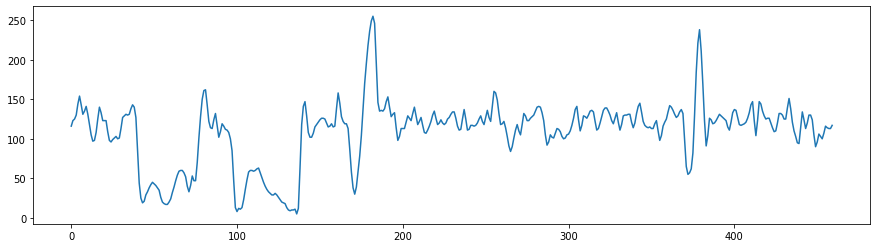

In [152]:
def data_crop(data, wl_ratio):
    data_len = data.shape[0]
    wl = int(data_len*wl_ratio)
    start = int(data_len*(1-wl_ratio)//2)
    end = start + wl
    print(start, end)
    crop_data = data[start:end]
    return crop_data
plt.figure(figsize=(15,4))
plt.plot(data_crop(myX, 0.9))

# 置换 
超参数：nPerm =要置换的段数 minSegLength =每个段最小长度

扰动数据段的位置，先将数据分割成N个相同的长度段，然后随机排列这些段


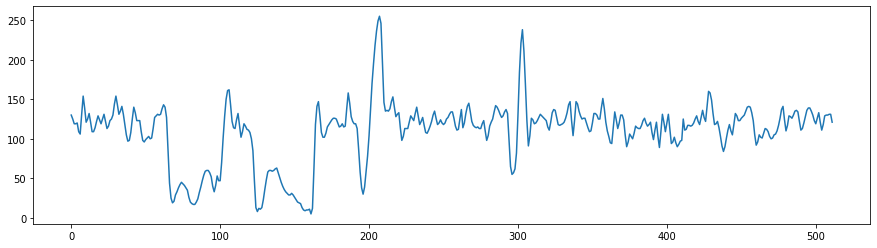

In [119]:
nPerm = 4
minSegLength = 100
def DA_Permutation(X, nPerm=4, minSegLength=10):
    bWhile = True
    while bWhile == True:　　　#　生成每块的起始索引
        indexs = np.zeros(nPerm+1, dtype=int)
        indexs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        indexs[-1] = X.shape[0]
        if np.min(indexs[1:]-indexs[:-1]) > minSegLength:  # 每段长度大于minSegLength
            bWhile = False
    # print(indexs)  # [   0  254 1094 1970 3600]
    pp = 0
    X_new = np.zeros(X.shape)
    seg_permu = np.random.permutation(nPerm)  # [1 0 3 2]　　打乱这些块
    
    for ii in range(nPerm):
        seg = seg_permu[ii]  #  第n块的块号 indexs[seg] 该块的索引
        # 二维
#         x_temp = X[indexs[seg]:indexs[seg+1],:]
#         X_new[pp:pp+len(x_temp),:] = x_temp  # 重新组合。
        
        # 一维
        x_temp = X[indexs[seg]:indexs[seg+1]]
        X_new[pp:pp+len(x_temp)] = x_temp  # 重新组合。
        pp += len(x_temp)
    return(X_new)

plt.figure(figsize=(15,4))
plt.plot(DA_Permutation(myX, nPerm, minSegLength))

# 随机抽样 

超参数：nSample =子样本数（nSample <= X.shape [0]）

此方法类似于TimeWarp，但将仅使用子样本（并非所有样本）进行插值。 （更推荐使用TimeWarp）

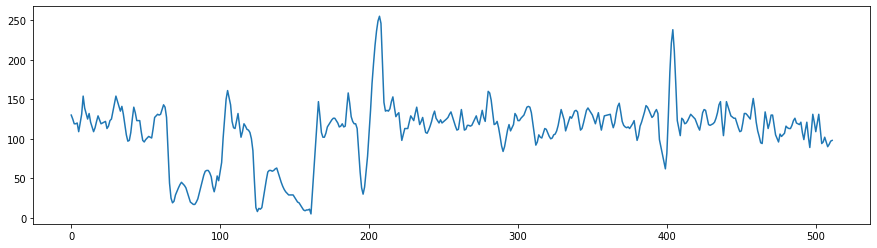

In [122]:
nSample = 1000
def RandSampleTimesteps(X, nSample=1000):
    X_new = np.zeros(X.shape)
    # 二维
#     tt = np.zeros((nSample,X.shape[1]), dtype=int)
#     tt[1:-1,0] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
#     tt[1:-1,1] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
#     tt[1:-1,2] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
#     tt[-1,:] = X.shape[0]-1
    
    
    # 一维
    tt = np.zeros((nSample), dtype=int)
    tt[1:-1] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[-1] = X.shape[0]-1
    return tt
def DA_RandSampling(X, nSample=1000):
    tt = RandSampleTimesteps(X, nSample)
    X_new = np.zeros(X.shape)
    # 二维
#     X_new[:,0] = np.interp(np.arange(X.shape[0]), tt[:,0], X[tt[:,0],0])
#     X_new[:,1] = np.interp(np.arange(X.shape[0]), tt[:,1], X[tt[:,1],1])
#     X_new[:,2] = np.interp(np.arange(X.shape[0]), tt[:,2], X[tt[:,2],2])

    # 一维
    X_new = np.interp(np.arange(X.shape[0]), tt, X[tt])
    return X_new
plt.figure(figsize=(15,4))
plt.plot(DA_RandSampling(myX, nSample))

# 降采样  
使用一组降采样因子 k1, k2, k3，每隔 ki-1 个数据取一个。

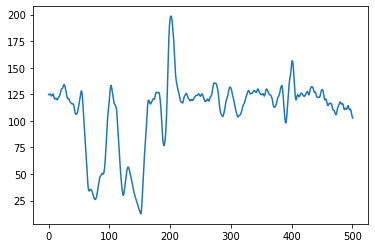

In [137]:
def down_sampling(data, rate):
    # down sampling by rate k
    if rate > data.shape[0] / 3:
        print('sampling rate is too high')
        return None
    ds_data = data[::rate]  # temp after down sampling
    ds_data_len = ds_data.shape[0]  # remark the length info
    return ds_data, ds_data_len

x,_ =moving_average(myX, 2)
plt.plot(x)

# 滑动平均  
使用一组滑动窗口l1, l2, l3，每li个数据取平均。

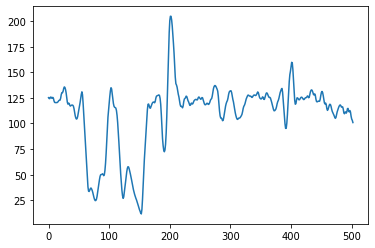

In [164]:
def moving_average(data, moving_wl=10):
    data_len = data.shape[0]
    if  moving_wl > data.shape[0] / 3:
        print('moving window is too high')
        return None
    ma_data = np.zeros(data_len-moving_wl+1)
    for i in range(data_len-moving_wl+1):
        ma_data[i] = np.mean(data[i: i+moving_wl])
    ma_data_len = ma_data.shape[0]
    return ma_data, ma_data_len

x, _ = moving_average(myX, 10)
plt.plot(x)